In [1]:
%matplotlib inline
import pandas as pd
import os
import re
from Bio import SeqIO
import pysam
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SearchIO
from pybedtools import BedTool
import numpy as np
import pybedtools
import multiprocessing
import re
import time
import matplotlib.pyplot as plt

/home/benjamin/anaconda3/lib/python3.5/site-packages/Bio/SearchIO/__init__.py:211: BiopythonExperimentalWarning: Bio.SearchIO is an experimental submodule which may undergo significant changes prior to its future official release.
  BiopythonExperimentalWarning)


In [2]:
def ID_filter_gff(_feature, _id):
    """
    This filter parses out the top level id form the 9th gff column form a REPET gff file.
    It has a specific search pattern for each feature type in column 2.
    _type is defined by the feature '_'.join(feature.split("_")[-2:])
    """
    _type = '_'.join(_feature.split("_")[-2:])
    if _type == 'REPET_TEs':

        TE_pattern = r'ID=[A-Z,a-z,0-9,-]*_[A-Z,a-z,0-9]*_[0-9]*_([^;| ]*)'
        TE_prog = re.compile(TE_pattern)
        TE_match = TE_prog.search(_id)

        try:
            return TE_match.group(1)
        except AttributeError:
            print(_id)

    if _type == 'REPET_SSRs':
        
        SSR_pattern = 'ID=[A-Z,a-z,0-9,-]*_[A-Z,a-z,0-9]*_[0-9]*_([A-Z,a-z,0-9,-]*)'
        SSR_prog = re.compile(SSR_pattern)
        SSR_match = SSR_prog.search(_id)
        return SSR_match.group(1)
    if _type == 'REPET_tblastx' or _type == 'REPET_blastx':
        #if "#" in _id:
        #     blast_pattern = 'ID=[A-Z,a-z,0-9,-]*_[A-Z,a-z,0-9]*_[0-9]*_([A-Z,a-z,0-9,-]*[_]?[A-Z,a-z,0-9,-]*[_|#|0-9]+?:[A-Z,a-z,0-9,-,:]*)'
        #else:
        #    blast_pattern = r'ID=[A-Z,a-z,0-9,-]*_[A-Z,a-z,0-9]*_[0-9]*_([\w+|:|-]*)'
        blast_prog = re.compile(r'ID=[A-Z,a-z,0-9,-]*_[A-Z,a-z,0-9]*_[0-9]*_([^;| ]*)')
        #blast_prog = re.compile(blast_pattern)
        blast_match = blast_prog.search(_id)
        return blast_match.group(1)


In [3]:
def blast_hit_gff(_feature, _row8, _id):
    """
    This filter parses the blast hit for REPET_TEs from the new 'ID' column. If no blast hit available returns Pastec ids.
    If the result is blast already the value is simple parse the blast hit.
    SSRs also get SSR
    !!!Requires the three_letter_dict to be defined previously.!!!
    _type is defined by the feature '_'.join(feature.split("_")[-2:])
    """
    _type = '_'.join(_feature.split("_")[-2:])
    if _type == 'REPET_TEs':
        #split the pastec_cat into the first three letter code
        pastec_cat = _id.split('_')[0]
        if 'TE_BLR' in _row8:
            #hit_list = [x.split(';')[3] for x in _row8]
            blast_hit_pattern = r'TE_BLR\w*: (\S*)[ |;]'
            blast_hit_prog = re.compile(blast_hit_pattern)
            TE_match = blast_hit_prog.findall(_row8)
            first_sub_class = ':'.join(TE_match[0][:-1].split(':')[1:])
            if len([x for x in TE_match if first_sub_class in x]) == len(TE_match):
                if ';' in first_sub_class:
                    return first_sub_class.split(';')[0]
                else:
                    return first_sub_class
#fix this here to include the there letter code of the first bit of the ID similar to the blast hits
#e.g. ClassI:?:? and so on. a dict might be the easiest here.
            
            else:
                return three_letter_dict[pastec_cat]
        else:
            return three_letter_dict[pastec_cat]
    if _type == 'REPET_SSRs':
        return 'SSR'
        

        return SSR_match.group(1)
    if _type == 'REPET_tblastx' or _type == 'REPET_blastx':
        return ':'.join(_id.split(':')[1:])

In [4]:
def TE_classification_filter(_id, level = 0):
    """
    This function pulls out the class == level1, Order == level2, Superfamily == leve3.
    If SSR or noCat return these values.
    
    """
    if len(_id.split(':')) == 1:
        return _id
    if level == 0:
        _class = _id.split(':')[0]
        if _class == 'ClassI':
            return 'Retrotransposon'
        if _class == 'ClassII':
            return 'DNA_transposon'
    elif level == 1:
        _order = _id.split(':')[1]
        if _order == '?':
            return 'noCat'
        else:
            return _order
    elif level == 2:
        _superfamily = _id.split(':')[2]
        if _superfamily == '?':
            return 'noCat'
        else:
            return _superfamily
    else:
        print('Something wrong! Check if level is 0, 1 or 2')

In [5]:
source_dir = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/032017_assembly'

In [6]:
genome = 'Pst_104E_v12_p_ctg'

In [7]:
out_dir = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/TE_analysis'

In [8]:
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

In [9]:
#remove all commenting lines from the initial repet file
!grep -v "^#" {source_dir}/{genome}.REPET.gff > {out_dir}/{genome}.REPET.gff

In [10]:
p_repet_gff = pd.read_csv(out_dir+'/'+genome+'.REPET.gff', sep='\t', header = None)

In [11]:
TE_post_analysis_p = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/REPET/Pst79_p/Pst79_p_full_annotate/postanalysis'

In [12]:
TE_post_analysis_p_header = 'TE      length  covg    frags   fullLgthFrags   copies  fullLgthCopies  meanId  sdId    minId   q25Id   medId   q75Id   maxId   meanLgth        sdLgth  minLgth q25Lgth medLgth q75Lgth maxLgth meanLgthPerc    sdLgthPerc      minLgthPerc  q25LgthPerc     medLgthPerc     q75LgthPerc     maxLgthPerc'.split(' ')

In [13]:
TE_post_analysis_p_header = [x for x in TE_post_analysis_p_header if x != '']

In [14]:
#this needs to be fixed up to pick the proper summary table
p_repet_summary_df = pd.read_csv(TE_post_analysis_p+'/'+'Pst79p_anno_chr_allTEs_nr_noSSR_join_path.annotStatsPerTE.tab' ,\
                                names = TE_post_analysis_p_header, header=None, sep='\t', skiprows=1 )

#check if I can filter the tab files for removing all TEs that are on the 2000 plus contigs
#remove tRNAs TEs with infernal

p_repet_summary_df['Code'] = p_repet_summary_df['TE'].apply(lambda x: x.split('_')[0])

code_keys = p_repet_summary_df['Code'].unique()

code_keys.sort()

code_long = ['DNA_transposon Helitron', 'DNA_transposon Helitron', 'DNA_transposon Helitron', 'DNA_transposon Maverick',\
            'DNA_transposon TIR', 'DNA_transposon TIR', 'DNA_transposon TIR', 'DNA_transposon TIR', 'DNA_transposon noCat',\
             'DNA_transposon MITE','DNA_transposon MITE', 'Potential Host Gene', 'Retrotransposon LINE', 'Retrotransposon LINE',\
             'Retrotransposon LINE','Retrotransposon LTR','Retrotransposon LTR', 'Retrotransposon LTR', 'Retrotransposon LTR', 'Retrotransposon PLE', \
             'Retrotransposon SINE',  'Retrotransposon SINE', 'Retrotransposon noCat', 'Retrotransposon LARD',\
             'Retrotransposon LARD', 'Retrotransposon TRIM', 'Retrotransposon TRIM', 'Retrotransposon noCat',  \
             'Retrotransposon DIRS','Retrotransposon DIRS','Retrotransposon DIRS','Retrotransposon DIRS',\
             'noCat', 'noCat']

code_dict = dict(zip(code_keys, code_long))

In [15]:
p_repet_summary_df['Code long'] = p_repet_summary_df['Code'].apply(lambda x: code_dict[x])
p_repet_summary_sum_df = pd.pivot_table(p_repet_summary_df, values=['covg', 'copies'], index='Code long', aggfunc=np.sum)
p_repet_summary_mean_df = pd.pivot_table(p_repet_summary_df, values='length', index='Code long', aggfunc=np.mean)
pd.concat([p_repet_summary_sum_df,p_repet_summary_mean_df], axis=1 )

,copies,covg,length
Code long,,,
DNA_transposon Helitron,1075,817566,2989.764706
DNA_transposon MITE,3789,886304,490.240741
DNA_transposon Maverick,268,345406,8562.666667
DNA_transposon TIR,19166,12711595,4020.474359
DNA_transposon noCat,5286,2376456,3034.734513
Potential Host Gene,1372,1375304,6120.490566
Retrotransposon DIRS,1337,1049299,6874.526316
Retrotransposon LARD,10752,4947564,5407.736111
Retrotransposon LINE,323,237992,4446.625000


In [16]:
#now filter the gff dataframe to delete all the high coverage contigs
#This might would have to be fixed as well. If we don't delete it as files should be already filtered
contigs_smaller_2000 = pd.read_csv('/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/032017_assembly/pcontig_smaller_2000.txt',\
                                  header=None)[0].tolist()

p_repet_gff = pd.read_csv(out_dir+'/'+genome+'.REPET.gff', sep='\t', header = None)

p_repet_gff_filtered = p_repet_gff[p_repet_gff[0].isin(contigs_smaller_2000)].reset_index(drop=True)

In [17]:
#filter out potential host genes
p_repet_gff_filtered = p_repet_gff_filtered[~p_repet_gff_filtered[8].str.contains("Potential")]

In [18]:
p_repet_gff_filtered['ID'] = p_repet_gff_filtered.apply(lambda row: ID_filter_gff(row[1], row[8]), axis=1)

In [19]:
#re-generate the code dict using the gff ID as Code keys


code_keys = p_repet_gff_filtered[p_repet_gff_filtered[1].str.contains('REPET_TE')]['ID'].unique()

code_keys = list({x.split('_')[0] for x in code_keys})

code_keys.sort()

code_long = ['DNA_transposon Helitron', 'DNA_transposon Helitron', 'DNA_transposon Helitron', 'DNA_transposon Maverick',\
            'DNA_transposon TIR', 'DNA_transposon TIR', 'DNA_transposon TIR', 'DNA_transposon TIR', 'DNA_transposon noCat',\
             'DNA_transposon MITE','DNA_transposon MITE', 'Potential Host Gene', 'Retrotransposon LINE', 'Retrotransposon LINE',\
             'Retrotransposon LINE','Retrotransposon LTR','Retrotransposon LTR', 'Retrotransposon LTR', 'Retrotransposon LTR', 'Retrotransposon PLE', \
             'Retrotransposon SINE',  'Retrotransposon SINE', 'Retrotransposon noCat', 'Retrotransposon LARD',\
             'Retrotransposon LARD', 'Retrotransposon TRIM', 'Retrotransposon TRIM', 'Retrotransposon noCat',  \
             'Retrotransposon DIRS','Retrotransposon DIRS','Retrotransposon DIRS','Retrotransposon DIRS',\
             'noCat', 'noCat']

if len(code_keys) == len(code_long):
    print("should be okay!")

code_dict = dict(zip(code_keys, code_long))

In [20]:
three_letter_code = list({x for x in code_keys})

three_letter_code.sort()

three_letter_values = []
for x in three_letter_code:
    if 'MITE' in x:
        _value = "ClassII:MITE:?"
        three_letter_values.append(_value)
        continue
    if 'LARD' in x:
        _value = 'ClassI:LARD:?'
        three_letter_values.append(_value)
        continue
    if 'TRIM' in x:
        _value = 'ClassI:TRIM:?'
        three_letter_values.append(_value)
        continue
    _value =''
    if x[0] == 'D':
        _value = _value + 'ClassII:'
    if x[0] == 'R':
        _value = _value + 'ClassI:'
    if x[0] != 'D' and x[0] != 'R':
        _value = 'noCat'
        three_letter_values.append(_value)
        continue
    if x[1] == 'T':
        _value = _value + 'TIR:?'
    if x[1] == 'H':
        _value = _value + 'Helitron:?'
    if x[1] == 'M':
        _value = _value + 'Maverick:?'
    if x[0:2] == 'DY':
        _value = _value + ':Crypton:?'
    if x[1] == 'X':
        _value = _value + '?:?'
    if x[1] == 'I':
        _value = _value + 'LINE:?'
    if x[1] == 'L':
        _value = _value + 'LTR:?'
    if x[1] == 'P':
        _value = _value + 'Penelope:?'
    if x[1] == 'S':
        _value = _value + 'SINE:?'
    if x[0:2] == 'RY':
        _value = _value + 'DIRS:?'    
    three_letter_values.append(_value)

if len(three_letter_code) == len(three_letter_values):
    print("Aas")
    three_letter_dict = dict(zip(three_letter_code, three_letter_values))

Aas


In [21]:
p_repet_gff_filtered['Class:Order:Superfamily'] = p_repet_gff_filtered.apply(lambda row: blast_hit_gff(row[1], row[8], row['ID']), axis=1)

In [22]:
#generate a dict that can be used to rename the Class:Order:Superfamily column considering that partial matches ([2] == match_part) might contain different
#IDs even though they are the same TE only partial.
_tmp_subset = p_repet_gff_filtered[~p_repet_gff_filtered[1].str.contains('SSR')].loc[:, 'ID':].sort_values(by=['ID','Class:Order:Superfamily'])\
.drop_duplicates(subset='ID', keep ='last')

TE_COS_dict = dict(zip(_tmp_subset.loc[:, 'ID'], _tmp_subset.loc[:, 'Class:Order:Superfamily' ]))

_tmp_subset = p_repet_gff_filtered[p_repet_gff_filtered[1].str.contains('SSR')].loc[:, 'ID':].sort_values(by=['ID','Class:Order:Superfamily'])\
.drop_duplicates(subset='ID', keep ='last')

_tmp_dict = dict(zip(_tmp_subset.loc[:, 'ID'], _tmp_subset.loc[:, 'Class:Order:Superfamily' ]))

TE_COS_dict.update(_tmp_dict)
#remove all backslashes from the values as this will conflict with the output later on
for x in TE_COS_dict.keys():
    if '/' in TE_COS_dict[x]:
        value = TE_COS_dict[x]
        print(value)
        TE_COS_dict[x] = value.replace('/','_')
        print(TE_COS_dict[x])

ClassII:?:Ginger2/TDD
ClassII:?:Ginger2_TDD


In [23]:
p_repet_gff_filtered.to_csv(out_dir+'/'+genome+'.REPET.long.df', sep='\t', header = None, index=None)

In [24]:
p_repet_gff_filtered['Class:Order:Superfamily'] = p_repet_gff_filtered['ID'].apply(lambda x: TE_COS_dict[x])

In [25]:
print('These are the unique Class:Order:Superfamily classifiers of this dataframe:')
print(p_repet_gff_filtered['Class:Order:Superfamily'].unique())

These are the unique Class:Order:Superfamily classifiers of this dataframe:
['ClassII:TIR:hAT' 'ClassII:TIR:CACTA' 'ClassI:LTR:Gypsy'
 'ClassII:TIR:PIF-Harbinger' 'ClassI:LTR:Copia' 'SSR' 'ClassII:?:?'
 'ClassII:MITE:?' 'ClassI:LTR:?' 'ClassI:LARD:?' 'ClassI:SINE:?'
 'ClassII:TIR:Tc1-Mariner' 'ClassII:TIR:?' 'ClassII:TIR:MuDR' 'noCat'
 'ClassII:Helitron:?' 'ClassII:TIR:P' 'ClassII:Helitron:Helitron'
 'ClassI:LTR:ERV' 'ClassII:Maverick:?' 'ClassI:LINE:I' 'ClassII:?:Academ'
 'ClassI:DIRS:DIRS' 'ClassII:?:Ginger2_TDD' 'ClassI:TRIM:?'
 'ClassI:LINE:Jockey' 'ClassI:?:?' 'ClassII:?:Ginger1'
 'ClassI:LTR:Retrovirus' 'ClassI:LTR:Bel-Pao' 'ClassII:Maverick:Maverick'
 'ClassI:PLE:Penelope' 'ClassI:Penelope:?' 'ClassI:LINE:RTE'
 'ClassI:LINE:?' 'ClassI:LINE:L1' 'ClassII:Crypton:Crypton'
 'ClassII:?:Sola' 'ClassII:TIR:PiggyBac' 'ClassI:LINE:R2' 'ClassI:DIRS:?'
 'ClassII:?:Kolobok' 'ClassII:TIR:Transib']


In [26]:
#have a rough summary of the coverage not considering overlaps.
p_repet_gff_filtered.drop_duplicates(subset=[3,4,'ID'], inplace =True)
p_repet_gff_filtered['Length'] = p_repet_gff_filtered[4] - p_repet_gff_filtered[3]
p_repet_gff_filtered['Class'] = p_repet_gff_filtered.apply(lambda row: TE_classification_filter(row['Class:Order:Superfamily'], 0), axis=1)
p_repet_gff_filtered['Order'] = p_repet_gff_filtered.apply(lambda row: TE_classification_filter(row['Class:Order:Superfamily'], 1), axis=1)
p_repet_gff_filtered['Superfamily'] = p_repet_gff_filtered.apply(lambda row: TE_classification_filter(row['Class:Order:Superfamily'], 2), axis=1)
p_repet_gff_len_COS = p_repet_gff_filtered.groupby(by=['Class','Order','Superfamily'])['Length'].sum()
p_repet_gff_len_S = p_repet_gff_filtered.groupby(by=['Class:Order:Superfamily'])['Length'].sum()

In [27]:
print("This is the summary of overlapping coverage according to Class, Order, Superfamily")
print(p_repet_gff_len_COS)

This is the summary of overlapping coverage according to Class, Order, Superfamily
Class            Order     Superfamily  
DNA_transposon   Crypton   Crypton              1980
                 Helitron  Helitron          1402086
                           noCat              773416
                 MITE      noCat             1089424
                 Maverick  Maverick            32983
                           noCat              411043
                 TIR       CACTA             2468455
                           MuDR              4269984
                           P                  273240
                           PIF-Harbinger     4470021
                           PiggyBac              345
                           Tc1-Mariner       3164294
                           Transib              1257
                           hAT               8656260
                           noCat             5176762
                 noCat     Academ            2069193
                           G

In [28]:
print("This is the summary of overlapping coverage according to Superfamily")
print(p_repet_gff_len_S)

This is the summary of overlapping coverage according to Superfamily
Class:Order:Superfamily
ClassI:?:?                     151904
ClassI:DIRS:?                    5222
ClassI:DIRS:DIRS              1288040
ClassI:LARD:?                 3354762
ClassI:LINE:?                    5056
ClassI:LINE:I                  886166
ClassI:LINE:Jockey              40186
ClassI:LINE:L1                   2500
ClassI:LINE:R2                   3941
ClassI:LINE:RTE                  2767
ClassI:LTR:?                  3003699
ClassI:LTR:Bel-Pao               4378
ClassI:LTR:Copia             12553952
ClassI:LTR:ERV                 140257
ClassI:LTR:Gypsy             29374783
ClassI:LTR:Retrovirus           29929
ClassI:PLE:Penelope               730
ClassI:Penelope:?               74409
ClassI:SINE:?                   32459
ClassI:TRIM:?                  207950
ClassII:?:?                   8367989
ClassII:?:Academ              2069193
ClassII:?:Ginger1                5331
ClassII:?:Ginger2_TDD            

In [29]:
num_unique_TEs = len(p_repet_gff_filtered[~p_repet_gff_filtered[1].str.contains('SSR')]['ID'].unique())
num_unique_TE_super = len(p_repet_gff_filtered[~p_repet_gff_filtered[1].str.contains('SSR')]['Class:Order:Superfamily'].unique())

print('This is the number of unique TEs: %i\nThis is the number of unique TE superfamilies: %i' % (num_unique_TEs, num_unique_TE_super))

This is the number of unique TEs: 12807
This is the number of unique TE superfamilies: 42


In [30]:
#check out some pivot tables for the TE summarize in the python book







In [31]:
p_repet_gff_filtered.groupby(by=['Class','Order','Superfamily'])['Length'].count() 


Class            Order     Superfamily  
DNA_transposon   Crypton   Crypton             11
                 Helitron  Helitron          3199
                           noCat              992
                 MITE      noCat             4084
                 Maverick  Maverick            42
                           noCat              281
                 TIR       CACTA             3584
                           MuDR              8939
                           P                  957
                           PIF-Harbinger    10660
                           PiggyBac             3
                           Tc1-Mariner       8122
                           Transib              7
                           hAT              20443
                           noCat             7366
                 noCat     Academ            2767
                           Ginger1             53
                           Ginger2_TDD          1
                           Kolobok              3
         

In [32]:
p_repet_gff_filtered.groupby(by=['Class:Order:Superfamily'])['Length'].count()

Class:Order:Superfamily
ClassI:?:?                     261
ClassI:DIRS:?                    8
ClassI:DIRS:DIRS              2875
ClassI:LARD:?                 5628
ClassI:LINE:?                   13
ClassI:LINE:I                 1889
ClassI:LINE:Jockey             239
ClassI:LINE:L1                  28
ClassI:LINE:R2                  11
ClassI:LINE:RTE                 36
ClassI:LTR:?                  6974
ClassI:LTR:Bel-Pao              25
ClassI:LTR:Copia             34361
ClassI:LTR:ERV                1547
ClassI:LTR:Gypsy             76311
ClassI:LTR:Retrovirus           88
ClassI:PLE:Penelope              6
ClassI:Penelope:?              114
ClassI:SINE:?                  171
ClassI:TRIM:?                  418
ClassII:?:?                  26106
ClassII:?:Academ              2767
ClassII:?:Ginger1               53
ClassII:?:Ginger2_TDD            1
ClassII:?:Kolobok                3
ClassII:?:Sola                  20
ClassII:Crypton:Crypton         11
ClassII:Helitron:?             

In [33]:
p_repet_gff_filtered.to_csv(out_dir+'/'+genome+'.REPET.long_v2.df', sep='\t', header = None, index=None)

In [43]:
#make new gff files where the ID column is the superfamily level
p_repet_gff_superfamily = p_repet_gff_filtered.iloc[:,:]
p_repet_gff_superfamily[8] = p_repet_gff_superfamily['Class:Order:Superfamily']
p_repet_gff_superfamily.iloc[:,0:9].to_csv(out_dir+'/'+genome+'.REPET.superfamily.gff', sep='\t', header = None, index=None,columns=None)

In [35]:
#make new gff file where the ID column is the TE level
p_repet_gff_TE = p_repet_gff_filtered.iloc[:,:]
p_repet_gff_TE[8] = p_repet_gff_TE['ID']
p_repet_gff_TE.iloc[:,0:9].to_csv(out_dir+'/'+genome+'.REPET.TE.gff', sep='\t', header = None, index=None,columns=None)

In [36]:
#generate the directory structure to safe specific coverage files
os.chdir(out_dir)
TE_types = ['Retrotransposon', 'DNA_transposon', 'noCat', 'SSR']
TE_path = [os.path.join(out_dir, x) for x in TE_types]
TE_path_dict = dict(zip(TE_types, TE_path))
for TE_type in TE_types:
    new_path = os.path.join(out_dir, TE_type)
    if not os.path.exists(new_path):
        os.mkdir(new_path)

In [37]:
# subset the id and safe in specific folder
# return the subsetted file as bedtool
def subset_id(_id, bed_object, repet_prefix):
    #ClassI are retrotransposon form blast
    if 'ClassI:' in _id:
        out_path = TE_path_dict['Retrotransposon']   
    #ClassII are DNA_transponson
    elif 'ClassII' in _id:
        out_path = TE_path_dict['DNA_transposon'] 
    #The rest with '_' should be REPET_TEs
    elif _id == 'noCat':
        out_path = TE_path_dict['noCat']
    #everything without '_' at the end should be SSR
    elif _id == 'SSR':
        out_path = TE_path_dict['SSR']
    out_fn = out_path+'/'+repet_prefix+'.'+_id+'.gff'
    result = bed_object.filter(id_filter, _id).saveas(out_fn)
    cov_fn = out_fn.replace('gff','cov')
    cov = result.genome_coverage(dz=True,g=p_genome_file)
    cov.saveas(cov_fn)
    #_len = len(pd.read_csv(cov_fn, header=None, sep='\t'))
    #_dict[_id] = _len
    #return pybedtools.BedTool(result.fn)

In [38]:
# Next, we create a function to pass only features for a particular
# featuretype.  This is similar to a "grep" operation when applied to every
# feature in a BedTool
def id_filter(feature, _id):
    if feature[8] == _id:
        return True
    return False

In [39]:
repet_prefix_TE = genome+'.REPET.TE'
repet_prefix_S = genome+'.REPET.superfamily'
p_genome_file = genome+'.genome_file'

In [56]:
#pull in the classification gff, make classification array, loop over array to save all the cov_dataframes
RE_TE_gff = pybedtools.BedTool(out_dir+'/'+genome+'.REPET.TE.gff')
g_TE = RE_TE_gff.remove_invalid().saveas(out_dir+'/'+genome+'.REPET.TE.bedobject')
#use the blast filtered dataframe as well
RE_S_gff = pybedtools.BedTool(out_dir+'/'+genome+'.REPET.superfamily.gff')
g_S = RE_S_gff.remove_invalid().saveas(out_dir+'/'+genome+'.REPET.superfamily.bedobject')

In [57]:
#use multiprocessing to do the bedcov genome coverage per classification. Keep track if everything is already done.
jobs = []
bed_file = g_S
superfamilies = p_repet_gff_superfamily[8].unique()
for superfamily in superfamilies:
    subset_id(superfamily, bed_file, repet_prefix_S)
    print('Doing %s' % superfamily)

Doing ClassII:TIR:hAT
Doing ClassII:TIR:CACTA
Doing ClassI:LTR:Gypsy
Doing ClassII:TIR:PIF-Harbinger
Doing ClassI:LTR:Copia
Doing SSR
Doing ClassII:?:?
Doing ClassII:MITE:?
Doing ClassI:LTR:?
Doing ClassI:LARD:?
Doing ClassI:SINE:?
Doing ClassII:TIR:Tc1-Mariner
Doing ClassII:TIR:?
Doing ClassII:TIR:MuDR
Doing noCat
Doing ClassII:Helitron:?
Doing ClassII:TIR:P
Doing ClassII:Helitron:Helitron
Doing ClassI:LTR:ERV
Doing ClassII:Maverick:?
Doing ClassI:LINE:I
Doing ClassII:?:Academ
Doing ClassI:DIRS:DIRS
Doing ClassII:?:Ginger2_TDD
Doing ClassI:TRIM:?
Doing ClassI:LINE:Jockey
Doing ClassI:?:?
Doing ClassII:?:Ginger1
Doing ClassI:LTR:Retrovirus
Doing ClassI:LTR:Bel-Pao
Doing ClassII:Maverick:Maverick
Doing ClassI:PLE:Penelope
Doing ClassI:Penelope:?
Doing ClassI:LINE:RTE
Doing ClassI:LINE:?
Doing ClassI:LINE:L1
Doing ClassII:Crypton:Crypton
Doing ClassII:?:Sola
Doing ClassII:TIR:PiggyBac
Doing ClassI:LINE:R2
Doing ClassI:DIRS:?
Doing ClassII:?:Kolobok
Doing ClassII:TIR:Transib


In [58]:
cur_dir = os.path.abspath(os.path.curdir)
#this caputures all REPET classifications add the superfamily level
class_cov_files = []
for dirpath, dirname, filenames in os.walk(cur_dir, topdown=True):
    if dirpath == cur_dir:
        continue
    cov_files = [dirpath +'/'+x for x in os.listdir(dirpath) if x.endswith('.cov') and repet_prefix_S in x]
    for file in cov_files:
        class_cov_files.append(file)

#make a large summary dataframe from all the cov files where the last 
df_list =[]
class_cov_files.sort()
for file in class_cov_files:
    print(file)
    tmp_df = pd.read_csv(file, sep='\t', header = None)
    tmp_df["Class:Order:Superfamily"] = file.split('.')[-2]
    tmp_df.drop_duplicates(inplace=True) #drop all the duplicates meaning same position in the genome and same superfamily
    df_list.append(tmp_df)
    print(file.split('.')[-2])

df_REPET_classification = pd.concat(df_list)
df_REPET_classification.to_csv(out_dir+'/'+ repet_prefix_S +'.cov', sep='\t', header =None, index=None)

cov_per_superfamily = df_REPET_classification.pivot_table(values=1, columns= "Class:Order:Superfamily", aggfunc='count')
cov_per_contig_per_superfamily = df_REPET_classification.groupby([0, "Class:Order:Superfamily"])[1].count()

/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/TE_analysis/DNA_transposon/Pst_104E_v12_p_ctg.REPET.superfamily.ClassII:?:?.cov
ClassII:?:?
/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/TE_analysis/DNA_transposon/Pst_104E_v12_p_ctg.REPET.superfamily.ClassII:?:Academ.cov
ClassII:?:Academ
/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/TE_analysis/DNA_transposon/Pst_104E_v12_p_ctg.REPET.superfamily.ClassII:?:Ginger1.cov
ClassII:?:Ginger1
/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/TE_analysis/DNA_transposon/Pst_104E_v12_p_ctg.REPET.superfamily.ClassII:?:Ginger2_TDD.cov
ClassII:?:Ginger2_TDD
/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/TE_analysis/DNA_transposon/Pst_104E_v12_p_ctg.REPET.superfamily.ClassII:?:Kolobok.cov
ClassII:?:Kolobok
/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/TE_analysis/DNA_transposon/Pst_104E_

In [285]:
cov_all_TEs = df_REPET_classification.drop_duplicates([0,1]) #this gets ride of the overlap between different TE families and classes
cov_all_TEs = len(cov_all_TEs)

In [286]:

#make superfamily df and add columns for Class, order and superfamily
cov_per_superfamily_df = cov_per_superfamily.append(pd.DataFrame.from_dict({'cov_all_TEs': cov_all_TEs}, orient='index'))
cov_per_superfamily_df.drop('Class:Order:Superfamily',inplace=True)#check if this is still necessary after re-run
cov_per_superfamily_df.rename(columns={0: 'bp'}, inplace=True)
cov_per_superfamily_df['%'] = cov_per_superfamily_df['bp']/genome_size*100
cov_per_superfamily_df['Class:Order:Superfamily'] = cov_per_superfamily_df.index

cov_per_superfamily_df['Class'] = cov_per_superfamily_df.apply(lambda row: TE_classification_filter(row['Class:Order:Superfamily'], 0), axis=1)
cov_per_superfamily_df['Order'] = cov_per_superfamily_df.apply(lambda row: TE_classification_filter(row['Class:Order:Superfamily'], 1), axis=1)
cov_per_superfamily_df['Superfamily'] = cov_per_superfamily_df.apply(lambda row: TE_classification_filter(row['Class:Order:Superfamily'], 2), axis=1)
cov_per_superfamily_df.to_csv(out_dir+'/'+genome+'.REPET.summary.tab', sep='\t')

In [ ]:
#consider combining these cov data frames into classes and orders as well and simply using those as id column, drop duplicats 
#use those as real coverage analysis at those level

In [ ]:
cur_dir = os.path.abspath(os.path.curdir)
#this caputures all REPET classifications add the superfamily level
class_cov_files = []
for dirpath, dirname, filenames in os.walk(cur_dir, topdown=True):
    if dirpath == cur_dir:
        continue
    cov_files = [dirpath +'/'+x for x in os.listdir(dirpath) if x.endswith('.cov') and repet_prefix_S in x]
    for file in cov_files:
        class_cov_files.append(file)

#make a large summary dataframe from all the cov files where the last 
df_list =[]
class_cov_files.sort()
for file in class_cov_files:
    tmp_df = pd.read_csv(file, sep='\t', header = None)
    tmp_df["Class"] = file.split('.')[-2].split(':')[0] #parse out the Class from the file name
    tmp_df.drop_duplicates(inplace=True) #drop all the duplicates meaning same position in the genome and same Class
    df_list.append(tmp_df)
    print(file.split('.')[-2].split(':')[0])

df_REPET_classification_class = pd.concat(df_list)
df_REPET_orderification_class.drop_duplicates(inplace=True)
df_REPET_classification_class.to_csv(out_dir+'/'+ repet_prefix_S.replace('superfamily', 'Class') +'.cov', sep='\t', header =None, index=None)

cov_per_class = df_REPET_classification_class.pivot_table(values=1, columns= "Class", aggfunc='count')
cov_per_contig_per_class = df_REPET_classification_class.groupby([0, "Class"])[1].count()

ClassII
ClassII
ClassII
ClassII
ClassII
ClassII
ClassII
ClassII
ClassII
ClassII
ClassII
ClassII
ClassII
ClassII
ClassII
ClassII
ClassII
ClassII
ClassII
ClassII
ClassII
ClassI
ClassI
ClassI
ClassI
ClassI
ClassI
ClassI
ClassI
ClassI
ClassI
ClassI
ClassI
ClassI
ClassI
ClassI
ClassI
ClassI
ClassI
ClassI
ClassI
SSR
noCat


In [ ]:
#this parsing of of the order is neccessary to eliminate any overlap at the order level. See drop duplicates line 23.
cur_dir = os.path.abspath(os.path.curdir)
#this caputures all REPET classifications add the superfamily level
class_cov_files = []
for dirpath, dirname, filenames in os.walk(cur_dir, topdown=True):
    if dirpath == cur_dir:
        continue
    cov_files = [dirpath +'/'+x for x in os.listdir(dirpath) if x.endswith('.cov') and repet_prefix_S in x]
    for file in cov_files:
        class_cov_files.append(file)

#make a large summary dataframe from all the cov files where the last 
df_list =[]
class_cov_files.sort()
for file in class_cov_files:
    tmp_df = pd.read_csv(file, sep='\t', header = None)
    if ':' in file:
        tmp_df["Order"] = ':'.join(file.split('.')[-2].split(':')[0:2]) #parse out the order from the file name
        print(':'.join(file.split('.')[-2].split(':')[0:2]))
    else:
        tmp_df["Order"] = file.split('.')[-2].split(':')[0]
        print(file.split('.')[-2].split(':')[0])
    tmp_df.drop_duplicates(inplace=True) #drop all the duplicates meaning same position in the genome and same Order
    df_list.append(tmp_df)

df_REPET_orderification_order = pd.concat(df_list)
df_REPET_orderification_order.drop_duplicates(inplace=True)
df_REPET_orderification_order.to_csv(out_dir+'/'+ repet_prefix_S.replace('superfamily', 'Order') +'.cov', sep='\t', header =None, index=None)

cov_per_order = df_REPET_orderification_order.pivot_table(values=1, columns= "Order", aggfunc='count')
cov_per_contig_per_order = df_REPET_orderification_order.groupby([0, "Order"])[1].count()

In [203]:
cov_per_order_df = cov_per_order.append(pd.DataFrame.from_dict({'cov_all_TEs': cov_all_TEs}, orient='index'))

cov_per_order_df.rename(columns={0: 'bp'}, inplace=True)

cov_per_order_df['%'] = round(cov_per_order_df['bp']/genome_size*100, 3)

In [204]:
cov_per_class_df = cov_per_class.append(pd.DataFrame.from_dict({'Total RE coverage': cov_all_TEs}, orient='index'))

cov_per_class_df.rename(columns={0: 'bp'}, inplace=True)

cov_per_class_df['%'] = round(cov_per_class_df['bp']/genome_size*100, 3)

cov_per_class_df.sort_values('%', inplace=True)

In [293]:
plt.style.available

['seaborn-darkgrid',
 'seaborn-poster',
 'seaborn-ticks',
 'seaborn-dark-palette',
 'grayscale',
 'seaborn-white',
 'seaborn-deep',
 'seaborn-talk',
 'seaborn-whitegrid',
 'fivethirtyeight',
 'classic',
 'seaborn-muted',
 'seaborn-pastel',
 'bmh',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-bright',
 'ggplot',
 'seaborn-colorblind',
 'seaborn-dark',
 'dark_background']

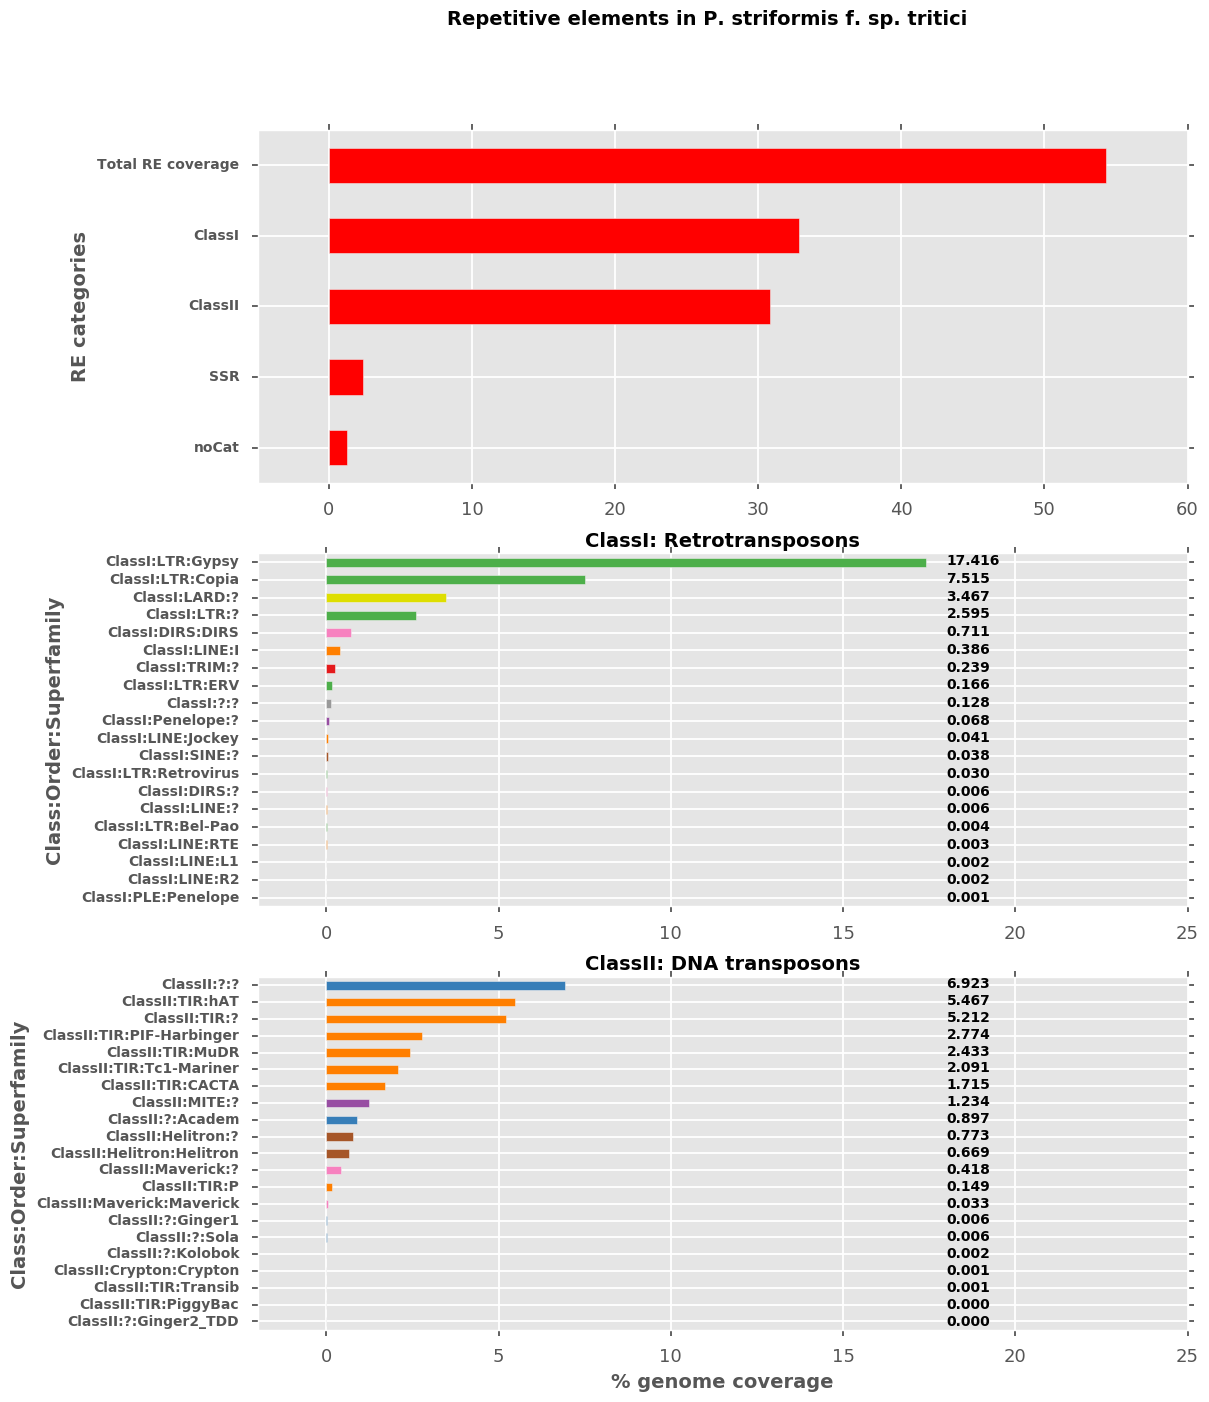

In [301]:
plt.style.use('seaborn-talk')
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(12,15))
fig.suptitle("Repetitive elements in P. striformis f. sp. tritici", fontsize=14, fontweight = 'bold')

#color cycle from color blind people 
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
'#999999', '#e41a1c', '#dede00']

#plot the overall genome coverage by repetitive element category
cov_per_class_df.plot(kind='barh', y='%', ax=ax0,  color='r')
ax0.set_xlim([-5,60])
ax0.legend().set_visible(False)
ax0.set_yticklabels(list(cov_per_class_df.index),fontsize=10, fontweight='bold')
ax0.set_ylabel(ylabel='RE categories', fontsize=14, fontweight='bold')

#plot class I 
classI_df = classI_df = cov_per_superfamily_df[cov_per_superfamily_df['Class'] == 'Retrotransposon'].sort_values('%')

#pick out the colors to do color matching on the order level
tmp_cn = len(classI_df['Order'].unique())
tmp_colors = CB_color_cycle[0:tmp_cn]
tmp_col_dict = dict(zip(classI_df['Order'].unique(), tmp_colors))
classI_df['Color'] = classI_df['Order'].apply(lambda x: tmp_col_dict[x])
classI_df.plot(kind='barh', y = '%', ax=ax1, color=classI_df['Color'])
ax1.set_xlim([-2,25])
ax1.legend().set_visible(False)
ax1.set_yticklabels(list(classI_df.index),fontsize=10, fontweight='bold')
ax1.set_ylabel(ylabel='Class:Order:Superfamily', fontsize=14, fontweight='bold')
ax1.set_title('ClassI: Retrotransposons', fontsize=14, fontweight='bold')

#add tick lables

for p, value in zip(ax1.patches, classI_df['%']):
    ax1.annotate('{0:.3f}'.format(value), (18,p.get_y() * 1.005),fontsize=10, fontweight='bold' )

#plot class II
classII_df = classII_df = cov_per_superfamily_df[cov_per_superfamily_df['Class'] == 'DNA_transposon'].sort_values('%')

#pick out the colors to do color matching on the order level
tmp_cn = len(classII_df['Order'].unique())
tmp_colors = CB_color_cycle[0:tmp_cn]
tmp_col_dict = dict(zip(classII_df['Order'].unique(), tmp_colors))
classII_df['Color'] = classII_df['Order'].apply(lambda x: tmp_col_dict[x])

#plot the class II out
classII_df.plot(kind='barh', y = '%', ax=ax2, color=classII_df['Color'])
ax2.set_xlim([-2,25])
ax2.legend().set_visible(False)
ax2.set_yticklabels(list(classII_df.index),fontsize=10, fontweight='bold')
ax2.set_ylabel(ylabel='Class:Order:Superfamily', fontsize=14, fontweight='bold')
ax2.set_title('ClassII: DNA transposons', fontsize=14, fontweight='bold')
ax2.set_xlabel('% genome coverage', fontsize=14, fontweight='bold')

#add tick lables

for p, value in zip(ax2.patches, classII_df['%']):
    ax2.annotate('{0:.3f}'.format(value), (18 ,p.get_y() * 1.005),fontsize=10, fontweight='bold' )
    
fig.savefig('REPET_summary.seaborn-talk.png', dpi=600, bbox_inches="tight")

In [120]:
list(cov_per_class_df.index)

['noCat', 'SSR', 'ClassII', 'ClassI', 'Total RE coverage']

In [158]:
len(classI_df['Order'].unique())

9

In [132]:
classI_df = cov_per_superfamily_df[cov_per_superfamily_df['Class'] == 'Retrotransposon'].sort_values('%')

0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5


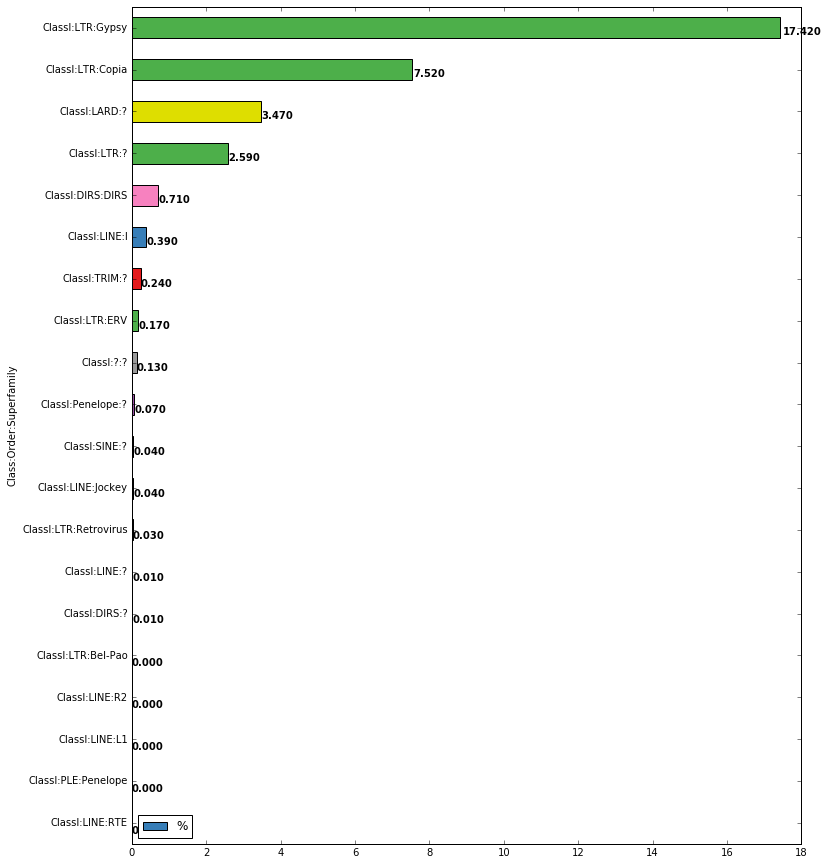

In [277]:
fig , ax = plt.subplots(nrows=1, ncols=1, figsize=(12,15))
tmp_cn = len(classI_df['Order'].unique())
tmp_colors = CB_color_cycle[0:tmp_cn]
tmp_col_dict = dict(zip(classI_df['Order'].unique(), tmp_colors))
classI_df['Color'] = classI_df['Order'].apply(lambda x: tmp_col_dict[x])
classI_df.plot(kind='barh', y = '%', ax=ax, color=classI_df['Color'])
for p, value in zip(ax.patches, classI_df['%']):
    print(p.get_height())
    ax.annotate(, (value * 1.005,p.get_y() * 1.005),fontsize=10, fontweight='bold' )
#tmp_order_dict = 
#for patch, color in zip(ax.get,colors):
#    patch.set_facecolor(color)

ValueError: labels ['Class:Order:Superfamily'] not contained in axis

In [275]:
cov_per_superfamily_df = cov_per_superfamily.append(pd.DataFrame.from_dict({'cov_all_TEs': cov_all_TEs}, orient='index'))
cov_per_superfamily_df.drop('Class:Order:Superfamily',inplace=True)#check if this is still necessary after re-run
cov_per_superfamily_df.rename(columns={0: 'bp'}, inplace=True)
cov_per_superfamily_df['%'] = cov_per_superfamily_df['bp']/genome_size*100
cov_per_superfamily_df['Class:Order:Superfamily'] = cov_per_superfamily_df.index

cov_per_superfamily_df['Class'] = cov_per_superfamily_df.apply(lambda row: TE_classification_filter(row['Class:Order:Superfamily'], 0), axis=1)
cov_per_superfamily_df['Order'] = cov_per_superfamily_df.apply(lambda row: TE_classification_filter(row['Class:Order:Superfamily'], 1), axis=1)
cov_per_superfamily_df['Superfamily'] = cov_per_superfamily_df.apply(lambda row: TE_classification_filter(row['Class:Order:Superfamily'], 2), axis=1)

In [276]:
cov_per_superfamily_df

,bp,%,Class:Order:Superfamily,Class,Order,Superfamily
Class:Order:Superfamily,,,,,,
ClassI:?:?,106360,0.127598,ClassI:?:?,Retrotransposon,noCat,noCat
ClassI:DIRS:?,5230,0.00627432,ClassI:DIRS:?,Retrotransposon,DIRS,noCat
ClassI:DIRS:DIRS,592849,0.711229,ClassI:DIRS:DIRS,Retrotransposon,DIRS,DIRS
ClassI:LARD:?,2889668,3.46667,ClassI:LARD:?,Retrotransposon,LARD,noCat
ClassI:LINE:?,5069,0.00608117,ClassI:LINE:?,Retrotransposon,LINE,noCat
ClassI:LINE:I,321797,0.386053,ClassI:LINE:I,Retrotransposon,LINE,I
ClassI:LINE:Jockey,33760,0.0405012,ClassI:LINE:Jockey,Retrotransposon,LINE,Jockey
ClassI:LINE:L1,2078,0.00249293,ClassI:LINE:L1,Retrotransposon,LINE,L1
ClassI:LINE:R2,1967,0.00235977,ClassI:LINE:R2,Retrotransposon,LINE,R2


In [ ]:







cov_per_superfamily_df['%'].plot.barh()
plt.xlabel('% genome coverage')
plt.ylabel('Class:Order:Superfamily')

In [272]:
genome_df = pd.read_csv(p_genome_file, sep='\t', header=None,names=['contig', 'length'])

genome_size = genome_df['length'].sum()

In [84]:
df_REPET_classification.head()

,0,1,2,Class:Order:Superfamily
0,pcontig_193,14248,2,ClassII:?:?
1,pcontig_193,14249,2,ClassII:?:?
2,pcontig_193,14250,2,ClassII:?:?
3,pcontig_193,14251,2,ClassII:?:?
4,pcontig_193,14252,2,ClassII:?:?


In [83]:
cov_per_superfamily_df

,bp,%,Class:Order:Superfamily,Class,Order,Superfamily
Class:Order:Superfamily,,,,,,
ClassI:?:?,106360,0.13,ClassI:?:?,Retrotransposon,noCat,noCat
ClassI:DIRS:?,5230,0.01,ClassI:DIRS:?,Retrotransposon,DIRS,noCat
ClassI:DIRS:DIRS,592849,0.71,ClassI:DIRS:DIRS,Retrotransposon,DIRS,DIRS
ClassI:LARD:?,2889668,3.47,ClassI:LARD:?,Retrotransposon,LARD,noCat
ClassI:LINE:?,5069,0.01,ClassI:LINE:?,Retrotransposon,LINE,noCat
ClassI:LINE:I,321797,0.39,ClassI:LINE:I,Retrotransposon,LINE,I
ClassI:LINE:Jockey,33760,0.04,ClassI:LINE:Jockey,Retrotransposon,LINE,Jockey
ClassI:LINE:L1,2078,0.00,ClassI:LINE:L1,Retrotransposon,LINE,L1
ClassI:LINE:R2,1967,0.00,ClassI:LINE:R2,Retrotransposon,LINE,R2


In [78]:
cov_per_contig_per_superfamily

0            Class:Order:Superfamily  
pcontig_000  ClassI:?:?                     3978
             ClassI:DIRS:?                    34
             ClassI:DIRS:DIRS              13911
             ClassI:LARD:?                109231
             ClassI:LINE:I                  6071
             ClassI:LINE:Jockey              415
             ClassI:LTR:?                 110248
             ClassI:LTR:Copia             201181
             ClassI:LTR:ERV                 3687
             ClassI:LTR:Gypsy             447680
             ClassI:LTR:Retrovirus            74
             ClassI:Penelope:?              1627
             ClassI:SINE:?                   636
             ClassI:TRIM:?                  8292
             ClassII:?:?                  222400
             ClassII:?:Academ              48483
             ClassII:?:Ginger1               261
             ClassII:?:Kolobok                45
             ClassII:?:Sola                  414
             ClassII:Helitron:

In [80]:
df_REPET_classification.groupby([0, "Class:Order:Superfamily"])[1].sum()

0            Class:Order:Superfamily  
pcontig_000  ClassI:?:?                     6108938732
             ClassI:DIRS:?                    70565249
             ClassI:DIRS:DIRS              25428761960
             ClassI:LARD:?                123853152866
             ClassI:LINE:I                 10581125052
             ClassI:LINE:Jockey              669894245
             ClassI:LTR:?                 118764382974
             ClassI:LTR:Copia             287680320449
             ClassI:LTR:ERV                 5007577181
             ClassI:LTR:Gypsy             688333565917
             ClassI:LTR:Retrovirus           195265761
             ClassI:Penelope:?              4226929005
             ClassI:SINE:?                   832169923
             ClassI:TRIM:?                 13796266175
             ClassII:?:?                  334337397327
             ClassII:?:Academ              74024866546
             ClassII:?:Ginger1               675343368
             ClassII:?:Kol

In [ ]:
p_repet_gff_filtered['Class'] = p_repet_gff_filtered.apply(lambda row: TE_classification_filter(row['Class:Order:Superfamily'], 0), axis=1)
p_repet_gff_filtered['Order'] = p_repet_gff_filtered.apply(lambda row: TE_classification_filter(row['Class:Order:Superfamily'], 1), axis=1)
p_repet_gff_filtered['Superfamily'] = p_repet_gff_filtered.apply(lambda row: TE_classification_filter(row['Class:Order:Superfamily'], 2), axis=1)

In [ ]:
cov_per_superfamily_df/genome_size

cov_per_class_noblast/genome_size

(cov_per_class/genome_size*100).sum()

(cov_per_class_noblast/genome_size*100).sum()

len(df_REPET_classification)

len(df_REPET_noblast_classification)

len(df_REPET_noblast_classification.drop_duplicates([0,1]))/genome_size

len(df_REPET_classification.drop_duplicates([0,1]))/genome_size

df_REPET_classification.head()

In [49]:
genome_size

83355616

## Thats how far we got ##

In [ ]:
#use multiprocessing to do the bedcov genome coverage per classification. Keep track if everything is already done.
jobs = []
bed_file = RE_S_gff
superfamilies = p_repet_gff_superfamily[8].unique()
for superfamily in superfamilies:
    p = multiprocessing.Process(target=subset_id, args=(superfamily, bed_file, repet_prefix_S,))
    jobs.append(p)
    p.start()
while set([j.is_alive() for j in jobs]) != {False}:
    time.sleep(60)
    print("Waiting for Subset_id_classification to finish!")
print("All Subset_id_classifications done!")

In [ ]:
#this caputures all REPET classifications including blast and internal REPET_TEs
#the problem found here is that the blast and the REPET annotation is sometimes contratictory and overlapping
class_cov_files = []
for dirpath, dirname, filenames in os.walk(cur_dir, topdown=True):
    if dirpath == cur_dir:
        continue
    cov_files = [dirpath +'/'+x for x in os.listdir(dirpath) if x.endswith('.cov') and 'REPET.classification' in x]
    for file in cov_files:
        class_cov_files.append(file)

#make a large summary dataframe from all the cov files where the last 
df_list =[]
class_cov_files.sort()
for file in class_cov_files:
    tmp_df = pd.read_csv(file, sep='\t', header = None)
    tmp_df["Code long"] = file.split('.')[-2]
    tmp_df.drop_duplicates(inplace=True)
    df_list.append(tmp_df)
    print(file.split('.')[-2])

df_REPET_classification = pd.concat(df_list)
df_REPET_classification.to_csv(out_dir+'/'+genome+'.REPET.classification.all.cov', sep='\t', header =None, index=None)

cov_per_class = df_REPET_classification.pivot_table(values=1, columns= 'Code long', aggfunc='count')
cov_per_contig_per_class = df_REPET_classification.groupby([0, 'Code long'])[1].count()


In [45]:
len(p_repet_gff_superfamily[8].unique())

43

In [44]:
p_repet_gff_superfamily[8]

0                   ClassII:TIR:hAT
2                 ClassII:TIR:CACTA
4                 ClassII:TIR:CACTA
6                 ClassII:TIR:CACTA
7                 ClassII:TIR:CACTA
8                 ClassII:TIR:CACTA
9                 ClassII:TIR:CACTA
11                ClassII:TIR:CACTA
13                ClassII:TIR:CACTA
15                ClassII:TIR:CACTA
17                ClassII:TIR:CACTA
19                ClassII:TIR:CACTA
21                ClassII:TIR:CACTA
23                ClassII:TIR:CACTA
25                ClassII:TIR:CACTA
27                ClassII:TIR:CACTA
29                ClassII:TIR:CACTA
31                ClassII:TIR:CACTA
33                ClassII:TIR:CACTA
35                ClassII:TIR:CACTA
37                ClassII:TIR:CACTA
39                ClassII:TIR:CACTA
41                ClassII:TIR:CACTA
43                ClassII:TIR:CACTA
45                ClassII:TIR:CACTA
47                ClassII:TIR:CACTA
49                 ClassI:LTR:Gypsy
51                 ClassI:LT

In [ ]:
p_repet_gff_superfamily[8]

In [ ]:
# Next, we create a function to pass only features for a particular
# featuretype.  This is similar to a "grep" operation when applied to every
# feature in a BedTool
def id_filter_col8(feature, _id):
    if feature[8] == _id:
        return True
    return False

In [ ]:
# subset the id and safe in specific folder
# return the subsetted file as bedtool
def subset_id_classification(_id, bed_object):
    #retrotransposon 
    if 'Retrotransposon' in _id:
        out_path = TE_path_dict['Retrotransposon']   
    #DNA_transponson
    elif 'DNA_transposon' in _id:
        out_path = TE_path_dict['DNA_transposon'] 
    #notCat 
    elif 'noCat' in _id:
        out_path = TE_path_dict['noCat']
    #SSR
    elif 'SSR' in _id:
        out_path = TE_path_dict['SSR']
    repet_prefix = genome+ '.'+bed_object.fn.split('.')[-3] + '.classification'
    out_fn = out_path+'/'+repet_prefix+'.'+_id+'.gff'
    out_fn= out_fn.replace(" ", '_')
    result = bed_object.filter(id_filter_classification, _id).saveas(out_fn)
    cov_fn = out_fn.replace('gff','cov')
    cov = result.genome_coverage(dz=True,g=p_genome_file)
    cov.saveas(cov_fn)
    print("Done with %s using %s as bedfile " % (out_fn.split('/')[-1], bed_object.fn.split('/')[-1]))
    #return pybedtools.BedTool(result.fn)

In [ ]:
#pull in the classification gff, make classification array, loop over array to save all the cov_dataframes
RE_id_gff = pybedtools.BedTool(out_dir+'/'+genome+'.REPET.classification.gff')
g = RE_id_gff.remove_invalid().saveas(out_dir+'/'+genome+'.REPET.classification.bedobject')
#use the blast filtered dataframe as well
RE_id_gff_noblast = pybedtools.BedTool(out_dir+'/'+genome+'.REPET_noblast.classification.gff')
g_noblast = RE_id_gff_noblast.remove_invalid().saveas(out_dir+'/'+genome+'.REPET_noblast.classification.bedobject')

In [ ]:
#use the blast filtered dataframe as well
RE_id_gff_blast = pybedtools.BedTool(out_dir+'/'+genome+'.REPET_blast.classification.gff')
g_blast = RE_id_gff_blast.remove_invalid().saveas(out_dir+'/'+genome+'.REPET_blast.classification.bedobject')

In [ ]:
#filter through the whole REPET_TE bedobject
#maybe make some multiproccesses out of this
classifications = p_repet_gff_filtered_2["Classification"].unique()
#[subset_id_classification(x, g) for x in classifications]

In [ ]:
#use multiprocessing to do the bedcov genome coverage per classification. Keep track if everything is already done.
jobs = []
bed_file = g
for classi in classifications:
    p = multiprocessing.Process(target=subset_id_classification, args=(classi, bed_file,))
    jobs.append(p)
    p.start()
while set([j.is_alive() for j in jobs]) != {False}:
    time.sleep(15)
    print("Waiting for Subset_id_classification to finish!")
print("All Subset_id_classifications done!")

In [ ]:
#generate a coverage file for each genome position from the gff without filtering for specific features
all_cov_RE = g.genome_coverage(dz=True,g=p_genome_file)
all_cov_RE.saveas('Pst_104E_v12_p_ctg.REPET.classification.cov')

In [ ]:
#print out the exitcodes for each
for j in jobs:
    #j.join()
    print('%s.exitcode = %s' % (j.name, j.exitcode))

In [ ]:
#filter through the whole REPET_TE bedobject having removed the blast hits
#maybe make some multiproccesses out of this
#use multiprocessing to do the bedcov genome coverage per classification. Keep track if everything is already done.
jobs = []
classifications_noblast = p_repet_gff_filtered_2[~p_repet_gff_filtered_2[1].str.contains('blast')]["Classification"].unique()
classifications = classifications_noblast
bed_file = g_noblast
for classi in classifications:
    p = multiprocessing.Process(target=subset_id_classification, args=(classi, bed_file,))
    jobs.append(p)
    p.start()
while set([j.is_alive() for j in jobs]) != {False}:
    time.sleep(15)
    print("Waiting for Subset_id_classification to finish!")
print("All Subset_id_classifications done!")
#print out the exitcodes for each
for j in jobs:
    #j.join()
    print('%s.exitcode = %s' % (j.name, j.exitcode))

In [ ]:
cur_dir = os.path.abspath(os.path.curdir)

In [ ]:
genome_df = pd.read_csv(p_genome_file, sep='\t', header=None,names=['contig', 'length'])

genome_size = genome_df['length'].sum()

In [ ]:
#this caputures all REPET classifications including blast and internal REPET_TEs
#the problem found here is that the blast and the REPET annotation is sometimes contratictory and overlapping
class_cov_files = []
for dirpath, dirname, filenames in os.walk(cur_dir, topdown=True):
    if dirpath == cur_dir:
        continue
    cov_files = [dirpath +'/'+x for x in os.listdir(dirpath) if x.endswith('.cov') and 'REPET.classification' in x]
    for file in cov_files:
        class_cov_files.append(file)

#make a large summary dataframe from all the cov files where the last 
df_list =[]
class_cov_files.sort()
for file in class_cov_files:
    tmp_df = pd.read_csv(file, sep='\t', header = None)
    tmp_df["Code long"] = file.split('.')[-2]
    tmp_df.drop_duplicates(inplace=True)
    df_list.append(tmp_df)
    print(file.split('.')[-2])

df_REPET_classification = pd.concat(df_list)
df_REPET_classification.to_csv(out_dir+'/'+genome+'.REPET.classification.all.cov', sep='\t', header =None, index=None)

cov_per_class = df_REPET_classification.pivot_table(values=1, columns= 'Code long', aggfunc='count')
cov_per_contig_per_class = df_REPET_classification.groupby([0, 'Code long'])[1].count()

In [ ]:
#this caputures all REPET classifications including internal REPET_TEs classification only. No blast hits included
class_cov_files = []
for dirpath, dirname, filenames in os.walk(cur_dir, topdown=True):
    if dirpath == cur_dir:
        continue
    cov_files = [dirpath +'/'+x for x in os.listdir(dirpath) if x.endswith('.cov') and 'REPET_noblast.classification' in x]
    for file in cov_files:
        class_cov_files.append(file)

#make a large summary dataframe from all the cov files where the last 
df_list =[]
class_cov_files.sort()
for file in class_cov_files:
    tmp_df = pd.read_csv(file, sep='\t', header = None)
    tmp_df["Code long"] = file.split('.')[-2]
    tmp_df.drop_duplicates(inplace=True)
    df_list.append(tmp_df)
    print(file.split('.')[-2])

df_REPET_noblast_classification = pd.concat(df_list)
df_REPET_noblast_classification.to_csv(out_dir+'/'+genome+'.REPET_noblast.classification.all.cov', sep='\t', header =None, index=None)
cov_per_class_noblast = df_REPET_noblast_classification.pivot_table(values=1, columns= 'Code long', aggfunc='count')
cov_per_contig_per_class_noblast = df_REPET_noblast_classification.groupby([0, 'Code long'])[1].count()

In [ ]:
df_REPET_classification.to_csv(out_dir+'/'+genome+'.REPET.classification.all.cov', sep='\t', header =None, index=None)

In [ ]:
cov_per_class/genome_size

cov_per_class_noblast/genome_size

(cov_per_class/genome_size*100).sum()

(cov_per_class_noblast/genome_size*100).sum()

len(df_REPET_classification)

len(df_REPET_noblast_classification)

len(df_REPET_noblast_classification.drop_duplicates([0,1]))/genome_size

len(df_REPET_classification.drop_duplicates([0,1]))/genome_size

df_REPET_classification.head()

In [ ]:
#look at the same graph with blast only searches and see what we get. Consider that a different parsing of ideas might be
#more appropriate in this case

## Below I am trying to sort out the cov files produced from bedfiles for each indiviudal TE element

In [ ]:
# Next, we create a function to pass only features for a particular
# featuretype.  This is similar to a "grep" operation when applied to every
# feature in a BedTool
def id_filter(feature, _id):
    if feature[8] == _id:
        return True
    return False

In [ ]:
# subset the id and safe in specific folder
# return the subsetted file as bedtool
def subset_id(_id):
    repet_prefix = 'Pst_104E_v12_p_ctg.REPET.TE_level'
    #ClassI are retrotransposon form blast
    if 'ClassI:' in _id:
        out_path = TE_path_dict['Retrotransposon']   
    #ClassII are DNA_transponson
    elif 'ClassII' in _id:
        out_path = TE_path_dict['DNA_transposon'] 
    #The rest with '_' should be REPET_TEs
    elif _id.split('_')[0] in list(code_dict.keys()):
        key = code_dict[_id.split('_')[0]].split(' ')[0]
        out_path = TE_path_dict[key]
    #everything without '_' at the end should be SSR
    elif '_' not in _id:
        out_path = TE_path_dict['SSR']
    out_fn = out_path+'/'+repet_prefix+'.'+_id+'.gff'
    result = REPET_ID_bed.filter(id_filter, _id).saveas(out_fn)
    cov_fn = out_fn.replace('gff','cov')
    cov = result.genome_coverage(dz=True,g=p_genome_file)
    cov.saveas(cov_fn)
    #_len = len(pd.read_csv(cov_fn, header=None, sep='\t'))
    #_dict[_id] = _len
    #return pybedtools.BedTool(result.fn)

In [ ]:
TE_types = ['Retrotransposon', 'DNA_transposon', 'noCat', 'SSR']
TE_path = [os.path.join(out_dir, x) for x in TE_types]
TE_path_dict = dict(zip(TE_types, TE_path))

In [ ]:
for TE_type in TE_types:
    new_path = os.path.join(out_dir, TE_type)
    if not os.path.exists(new_path):
        os.mkdir(new_path)

In [ ]:
_id = pd.read_csv(out_dir+'/'+genome+'.REPET.ID_column.gff', header=None, sep='\t')[8].unique()
REPET_ID_bed = pybedtools.BedTool(out_dir+'/'+genome+'.REPET.ID_column.gff')
REPET_ID_bed = REPET_ID_bed.remove_invalid().saveas(out_dir+'/'+genome+'.REPET.ID_column.bedobject')


In [ ]:
#use multiprocessing to do the bedcov genome coverage per classification. Keep track if everything is already done.

jobs = []
bed_file = g
total_jobs = len(_id)
job_count = 0
manager = multiprocessing.Manager()
TE_cov_df  = manager.dict()
while job_count < total_jobs:
    while [j.is_alive() for j in jobs].count(True) > 50:
        time.sleep(15)
        print("Waiting for Subset_id_classification to finish! More than 10 jobs running")
        print('%s jobs started' % job_count)
    if job_count +10 < total_jobs:
        for i in range(job_count, job_count+10):
            p = multiprocessing.Process(target=subset_id, args=([_id[i],TE_cov_df]))
            jobs.append(p)
            p.start()
            job_count += 1
            
    else:
        for i in range(job_count, total_jobs+1):
            p = multiprocessing.Process(target=subset_id, args=([_id[i], TE_cov_df]))
            jobs.append(p)
            p.start()
            job_count += 1
while set([j.is_alive() for j in jobs]) != {False}:
    time.sleep(15)
    print("Waiting for Subset_id_classification to finish!")
print("All Subset_id_classifications done! Totaling %i"% (job_count))


In [ ]:
print(job_count)

In [ ]:
# subset the id and safe in specific folder
# return the subsetted file as bedtool
def subset_id_q(_id_list, out_q):
    outdict ={}
    repet_prefix = 'Pst_104E_v12_p_ctg.REPET.TE_level'
    for _id in _id_list:
    
        #ClassI are retrotransposon form blast
        if 'ClassI:' in _id:
            out_path = TE_path_dict['Retrotransposon']   
        #ClassII are DNA_transponson
        elif 'ClassII' in _id:
            out_path = TE_path_dict['DNA_transposon'] 
        #The rest with '_' should be REPET_TEs
        elif _id.split('_')[0] in list(code_dict.keys()):
            key = code_dict[_id.split('_')[0]].split(' ')[0]
            out_path = TE_path_dict[key]
        #everything without '_' at the end should be SSR
        elif '_' not in _id:
            out_path = TE_path_dict['SSR']
        out_fn = out_path+'/'+repet_prefix+'.'+_id+'.gff'
        result = REPET_ID_bed.filter(id_filter, _id).saveas(out_fn)
        cov_fn = out_fn.replace('gff','cov')
        cov = result.genome_coverage(dz=True,g=p_genome_file)
        cov.saveas(cov_fn)
        _len = len(pd.read_csv(cov_fn, header=None, sep='\t'))
        outdict[_id] = _len
    out_q.put(outdict)
    #return pybedtools.BedTool(result.fn)

In [ ]:
#use multiprocessing to do the bedcov genome coverage per classification. Keep track if everything is already done.
import math
out_q = multiprocessing.Queue()
nproces = 30 #number of processors
chunksize = int(math.ceil(len(_id) / float(nproces)))
jobs = []
job_count = 0
#manager = multiprocessing.Manager()
#TE_cov_df  = manager.dict()
for i in range(nproces):
        p = multiprocessing.Process(target=subset_id_q, args=(_id[chunksize * i:chunksize * (i + 1)],out_q))
        jobs.append(p)
        p.start()
        job_count += 1
# Collect all results into a single result dict. We know how many dicts
# with results to expect.
resultdict = {}
for i in range(nproces):
    resultdict.update(out_q.get())

# Wait for all worker processes to finish
for p in jobs:
    p.join()

        
        
while set([j.is_alive() for j in jobs]) != {False}:
    time.sleep(15)
    print("Waiting for Subset_id_classification to finish!")
print("All Subset_id_classifications done! Totaling %i"% (job_count))

In [ ]:
len(_id)

In [ ]:
p = multiprocessing.Pool(20)
p.map(subset_id, _id)

In [ ]:
# subset the id and safe in specific folder
# return the subsetted file as bedtool
def subset_id_m(_id,):
    repet_prefix = 'Pst_104E_v12_p_ctg.REPET.TE_level'
    #ClassI are retrotransposon form blast
    if 'ClassI:' in _id:
        out_path = TE_path_dict['Retrotransposon']   
    #ClassII are DNA_transponson
    elif 'ClassII' in _id:
        out_path = TE_path_dict['DNA_transposon'] 
    #The rest with '_' should be REPET_TEs
    elif _id.split('_')[0] in list(code_dict.keys()):
        key = code_dict[_id.split('_')[0]].split(' ')[0]
        out_path = TE_path_dict[key]
    #everything without '_' at the end should be SSR
    elif '_' not in _id:
        out_path = TE_path_dict['SSR']
    out_fn = out_path+'/'+repet_prefix+'.'+_id+'.gff'
    result = REPET_ID_bed.filter(id_filter, _id).saveas(out_fn)
    cov_fn = out_fn.replace('gff','cov')
    cov = result.genome_coverage(dz=True,g=p_genome_file)
    cov.saveas(cov_fn)
    #_len = len(pd.read_csv(cov_fn, header=None, sep='\t'))
    #_dict[_id] = _len
    #return pybedtools.BedTool(result.fn)

In [ ]:

jobs = []
bed_file = g
total_jobs = len(_id)
job_count = 0
manager = multiprocessing.Manager()
TE_cov_df  = manager.dict()

    while [j.is_alive() for j in jobs].count(True) > 10:
        time.sleep(15)
        print("Waiting for Subset_id_classification to finish! More than 10 jobs running")
        print('%s jobs started' % job_count)
    if job_count +10 < total_jobs:
        for i in range(job_count, job_count+10):
            p = multiprocessing.Process(target=subset_id, args=([_id[i],TE_cov_df]))
            jobs.append(p)
            p.start()
            job_count += 1
            
    else:
        for i in range(job_count, total_jobs+1):
            p = multiprocessing.Process(target=subset_id, args=([_id[i], TE_cov_df]))
            jobs.append(p)
            p.start()
            job_count += 1
while set([j.is_alive() for j in jobs]) != {False}:
    time.sleep(15)
    print("Waiting for Subset_id_classification to finish!")
print("All Subset_id_classifications done! Totaling %i"% (job_count))


In [ ]:
for x in TE_cov_df.keys():
    print(x)

In [ ]:
[j.is_alive() for j in jobs].count(True)

In [ ]:
count = 0
while count < 10:
    count += 1
print(count)

In [ ]:
#this is REALLY slow for now. Would need to parallize this step. Look at the pool function of 
#multiprocessing

In [ ]:
[subset_id(x) for x in _id]

In [ ]:
#this caputures all REPET cov files for each indiviual TE.
class_cov_files = []
for dirpath, dirname, filenames in os.walk(cur_dir):
    #print(dirpath)
    #print(len(filenames))
    if len(filenames) == 0:  # empty folder
        continue
    cov_files = [dirpath +'/'+x for x in filenames if x.endswith('.cov') and 'classification' not in x ]
    for file in cov_files:
        class_cov_files.append(file)


In [ ]:
filenames

In [ ]:
!pwd

In [ ]:
len(cov_files)

In [ ]:

#make a large summary dataframe from all the cov files where the last 
df_list =[]
class_cov_files.sort()
for file in class_cov_files:
    tmp_df = pd.read_csv(file, sep='\t', header = None)
    tmp_df["Code long"] = file.split('.')[-2]
    tmp_df.drop_duplicates(inplace=True)
    df_list.append(tmp_df)
    print(file.split('.')[-2])

df_REPET_noblast_classification = pd.concat(df_list)

cov_per_class_noblast = df_REPET_noblast_classification.pivot_table(values=1, columns= 'Code long', aggfunc='count')
cov_per_contig_per_class_noblast = df_REPET_noblast_classification.groupby([0, 'Code long'])[1].count()